In [29]:
import os
import time
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB0, ResNet50
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, image

#--------------------------------------------------------------------------------------#

print(f'Tensorflow Version: {tf.__version__}')

print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

#--------------------------------------------------------------------------------------#

import warnings

warnings.filterwarnings("ignore")

Tensorflow Version: 2.15.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [30]:
# helper functions

#--------------------------------------------------------------------------------------#

def data_appender(data, path, folder):
    folderpath = os.path.join(path, folder)
    files = os.listdir(folderpath)
    
    for file in files:
        filepath = os.path.join(folderpath, file)
        data['imgpath'].append(filepath)
        data['labels'].append(folder)
    
    return data

#--------------------------------------------------------------------------------------#

def dataset_splitter(dataset, train_size = 0.75, test_size = 0.25, shuffle = True, random_state = 0):
    train_df, temp_df = train_test_split(dataset, train_size = train_size, 
                                         shuffle = shuffle, random_state = random_state)
    
    val_df, test_df = train_test_split(temp_df, test_size = test_size, 
                                       shuffle = shuffle, random_state = random_state)

    train_df = train_df.reset_index(drop = True)
    val_df = val_df.reset_index(drop = True)
    test_df = test_df.reset_index(drop = True)
    
    return train_df, val_df, test_df

#--------------------------------------------------------------------------------------#

In [31]:
data = {'imgpath': [], 'labels': []}
path = '/kaggle/input/facial-problem-4/facial_problem'
folders = [
    'Acne',
    'ActinicKeratosis',
    'Blackheads',
    'Herpes',
    'Keloid',
    'KeratosisSeborrheic',
    'Milia',
    'Pityriasis versicolor',
    'Ringworm'
]

for folder in folders:
    data = data_appender(data = data, path = path, folder = folder)

dataset = pd.DataFrame(data)
dataset.head()

,imgpath,labels
0,/kaggle/input/facial-problem-4/facial_problem/...,Acne
1,/kaggle/input/facial-problem-4/facial_problem/...,Acne
2,/kaggle/input/facial-problem-4/facial_problem/...,Acne
3,/kaggle/input/facial-problem-4/facial_problem/...,Acne
4,/kaggle/input/facial-problem-4/facial_problem/...,Acne


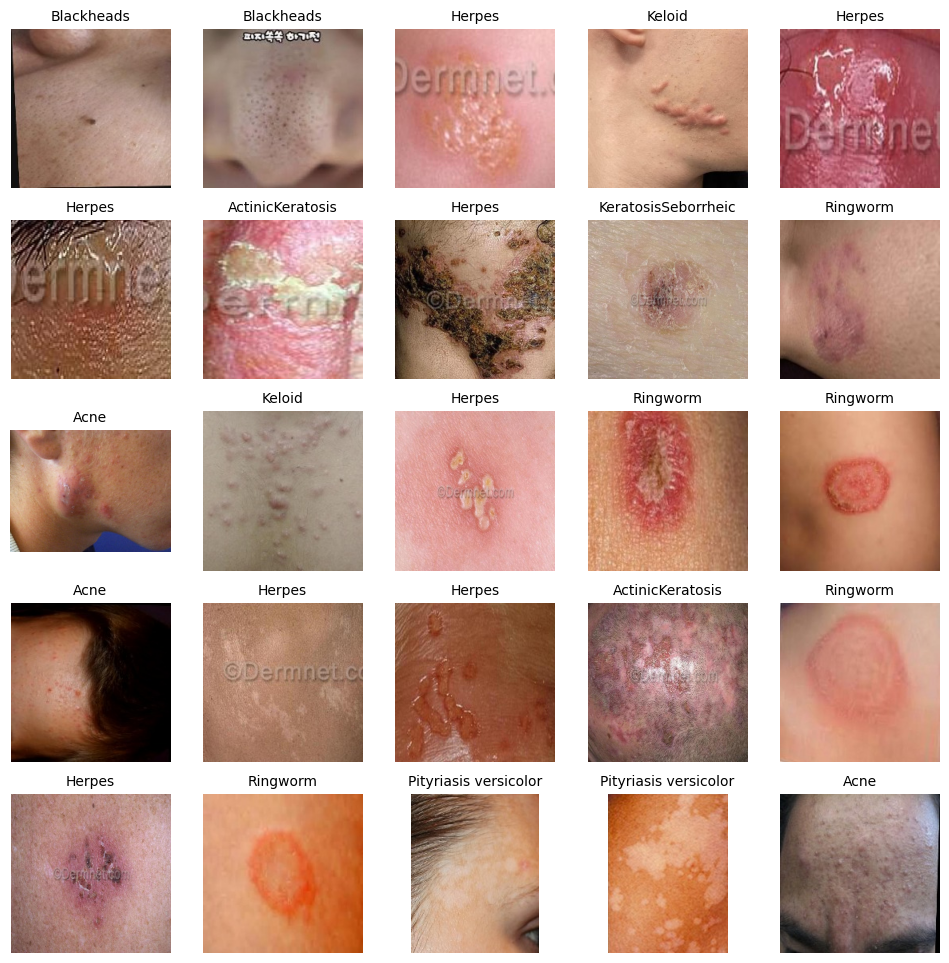

In [32]:
rows = 5
cols = 5

selected_indices = random.sample(range(len(dataset)), rows * cols)

fig, axes = plt.subplots(rows, cols, figsize = (12, 12))
gs = gridspec.GridSpec(rows, cols, wspace = 0.0, hspace = 0.0)

for i, idx in enumerate(selected_indices):
    row = i // cols
    col = i % cols
    img_path = dataset['imgpath'].iloc[idx]
    label = dataset['labels'].iloc[idx]
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
    axes[row, col].set_title(label, fontsize = 10)

plt.show()

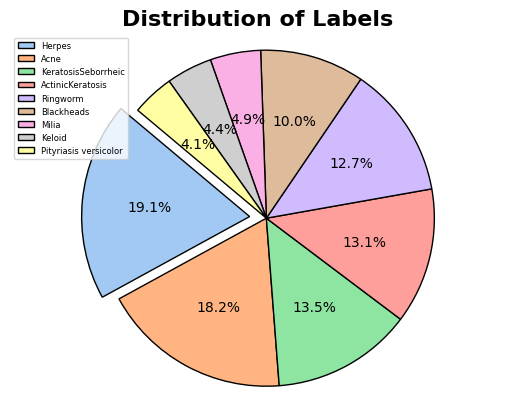

In [33]:
# Count the number of occurrences of each label
sizes = dataset['labels'].value_counts().values
labels = dataset['labels'].value_counts().index
colors = sns.color_palette('pastel')

# Generate the explode array dynamically
explode = [0.1] + [0] * (len(sizes) - 1)

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=140, 
                                  explode=explode, wedgeprops=dict(edgecolor='black'))

ax.set_title('Distribution of Labels', fontsize=16, fontweight='bold')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.legend(wedges, labels, loc = "best", fontsize = 6)

# Display the pie chart
plt.show()

In [34]:
train_df, val_df, test_df = dataset_splitter(dataset)

print(f'\nTraining Dataframe of shape {train_df.shape}: \n{train_df.head()}')
print(f'\nValidation Dataframe of shape {val_df.shape}: \n{val_df.head()}')
print(f'\nTesting Dataframe of shape {test_df.shape}: \n{test_df.head()}')


Training Dataframe of shape (1882, 2): 
                                             imgpath            labels
0  /kaggle/input/facial-problem-4/facial_problem/...        Blackheads
1  /kaggle/input/facial-problem-4/facial_problem/...            Herpes
2  /kaggle/input/facial-problem-4/facial_problem/...              Acne
3  /kaggle/input/facial-problem-4/facial_problem/...        Blackheads
4  /kaggle/input/facial-problem-4/facial_problem/...  ActinicKeratosis

Validation Dataframe of shape (471, 2): 
                                             imgpath            labels
0  /kaggle/input/facial-problem-4/facial_problem/...              Acne
1  /kaggle/input/facial-problem-4/facial_problem/...  ActinicKeratosis
2  /kaggle/input/facial-problem-4/facial_problem/...        Blackheads
3  /kaggle/input/facial-problem-4/facial_problem/...  ActinicKeratosis
4  /kaggle/input/facial-problem-4/facial_problem/...          Ringworm

Testing Dataframe of shape (157, 2): 
                          

In [35]:
# Define the seed, batch size, and image size
seed = 0
batch_size = 4
img_size = (224, 224)

# Define the augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode='nearest',
    rescale=1./255  # Ensure you rescale the images
)

# Apply the augmentation to the training data generator
train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True,
    seed=seed
)

# For validation and test data, use a generator without augmentation but with rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)
val_data = validation_datagen.flow_from_dataframe(
    val_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

test_data = validation_datagen.flow_from_dataframe(
    test_df,
    x_col='imgpath',
    y_col='labels',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=False
)

Found 1882 validated image filenames belonging to 9 classes.
Found 471 validated image filenames belonging to 9 classes.
Found 157 validated image filenames belonging to 9 classes.


In [36]:
from tensorflow.keras.applications import InceptionV3

# Define the model with additional Dropout for regularization
base_model= InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False

In [37]:
# top_model = Sequential()
# top_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=base_model.output_shape[1:]))
# top_model.add(MaxPooling2D(pool_size=(2, 2)))
# top_model.add(Flatten())
# top_model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# top_model.add(BatchNormalization())
# top_model.add(Dropout(0.5))
# top_model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# top_model.add(BatchNormalization())
# top_model.add(Dropout(0.2))
# top_model.add(Dense(len(folders), activation='softmax'))

model = Sequential([
    Input(shape=img_size + (3,), name='input_layer'),
    base_model,
    GlobalAveragePooling2D(),  # Flatten the output of the base model
    Dense(512, activation='relu'),
    Dropout(0.4, seed=seed),
    Dense(256, activation='relu'),
    Dropout(0.4, seed=seed),
    Dense(len(set(train_data.classes)), activation='softmax', name='output_layer')
])

model.compile(optimizer = Adam(learning_rate = 0.0001), 
              loss = CategoricalCrossentropy(), metrics = ['accuracy'])

model.summary()


# top_model = Sequential()
# top_model.add(Input(shape=base_model.output_shape[1:]))  # Use Input layer to specify the shape
# top_model.add(GlobalAveragePooling2D())
# top_model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
# top_model.add(Dropout(0.4))
# top_model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Assuming y_train is your label data

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,985,513 (87.68 MB)

 Trainable params: 1,182,729 (4.51 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [38]:
# input_tensor = Input(shape=(224, 224, 3))
# base_model_output = base_model(input_tensor)
# top_model_output = top_model(base_model_output)
# model = Model(inputs=input_tensor, outputs=top_model_output)

# for layer in base_model.layers:
#     layer.trainable = False
    
    
# model.summary()


model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, mode = 'min', patience=5, min_lr=0.00001)

history = model.fit(train_data, validation_data = val_data, 
                    epochs = 100, callbacks = [model_es, model_rlr])

Epoch 1/100
  4/471 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.0365 - loss: 2.2502     

W0000 00:00:1718261604.440587    3725 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


172/471 ━━━━━━━━━━━━━━━━━━━━ 33s 112ms/step - accuracy: 0.1926 - loss: 2.3203

W0000 00:00:1718261623.479267    3726 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2831 - loss: 2.0875

W0000 00:00:1718261648.983496    3726 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718261655.445195    3725 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


471/471 ━━━━━━━━━━━━━━━━━━━━ 70s 109ms/step - accuracy: 0.2833 - loss: 2.0870 - val_accuracy: 0.6200 - val_loss: 1.2801 - learning_rate: 1.0000e-04
Epoch 2/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.5034 - loss: 1.4395 - val_accuracy: 0.6582 - val_loss: 1.0421 - learning_rate: 1.0000e-04
Epoch 3/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step - accuracy: 0.5817 - loss: 1.2748 - val_accuracy: 0.7176 - val_loss: 0.9518 - learning_rate: 1.0000e-04
Epoch 4/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.6251 - loss: 1.0835 - val_accuracy: 0.7197 - val_loss: 0.9069 - learning_rate: 1.0000e-04
Epoch 5/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.6103 - loss: 1.1029 - val_accuracy: 0.7261 - val_loss: 0.8033 - learning_rate: 1.0000e-04
Epoch 6/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.6727 - loss: 0.9380 - val_accuracy: 0.7643 - val_loss: 0.7531 - learning_rate: 1.0000e-04
Epoch 7/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - 

In [39]:
test_results = model.evaluate(test_data, verbose=1)

print(f'Test Loss: {test_results[0]:.5f}')
print(f'Test Accuracy: {(test_results[1] * 100):.2f}%')

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.8887 - loss: 0.3805
Test Loss: 0.39862
Test Accuracy: 87.90%


In [40]:
# Get the class labels from the training data
class_labels = list(train_data.class_indices.keys())

# Get the true classes from the test data
test_classes = test_data.classes

# Predict the classes for the test data
predicted_classes = np.argmax(model.predict(test_data, verbose=0), axis=1)

# Print the classification report
print(f'Classification Report (Test) --> \n\n' + \
      f'{classification_report(test_classes, predicted_classes, target_names=class_labels)}')

W0000 00:00:1718263548.403001    3727 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report (Test) --> 

                       precision    recall  f1-score   support

                 Acne       0.88      1.00      0.94        22
     ActinicKeratosis       0.90      0.53      0.67        17
           Blackheads       1.00      0.95      0.97        20
               Herpes       0.83      0.91      0.87        32
               Keloid       0.67      0.57      0.62         7
  KeratosisSeborrheic       0.90      0.95      0.93        20
                Milia       0.78      0.88      0.82         8
Pityriasis versicolor       1.00      0.89      0.94         9
             Ringworm       0.88      0.95      0.91        22

             accuracy                           0.88       157
            macro avg       0.87      0.85      0.85       157
         weighted avg       0.88      0.88      0.87       157



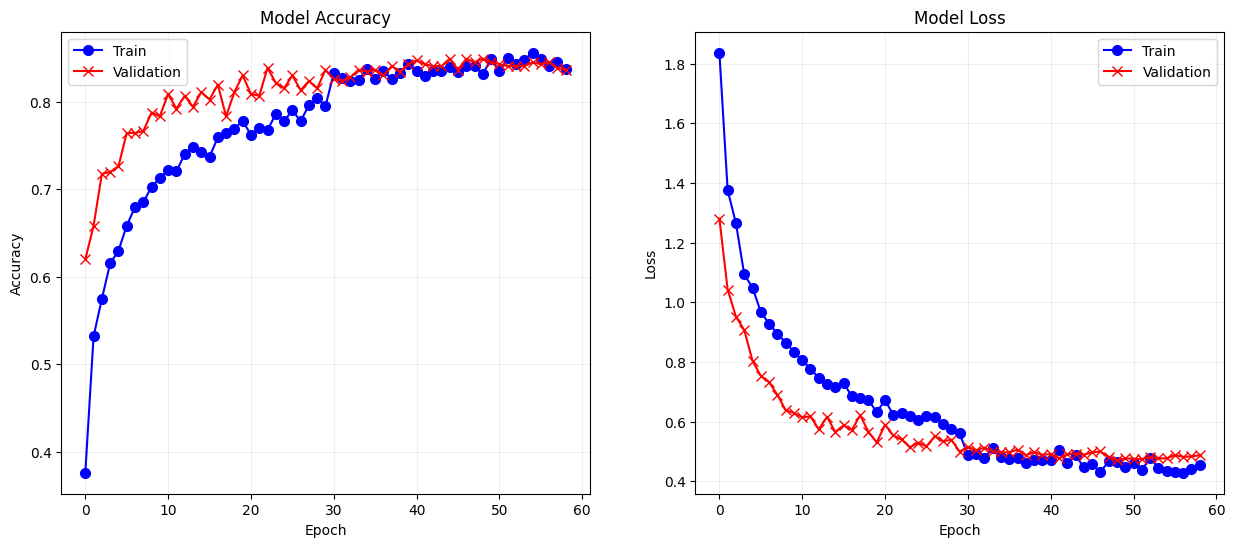

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))

# accuracy
ax[0].plot(history.history['accuracy'], marker='o', color='blue', markersize=7)
ax[0].plot(history.history['val_accuracy'], marker='x', color='red', markersize=7)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# loss
ax[1].plot(history.history['loss'], marker='o', color='blue', markersize=7)
ax[1].plot(history.history['val_loss'], marker='x', color='red', markersize=7)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


W0000 00:00:1718263563.996325    3728 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


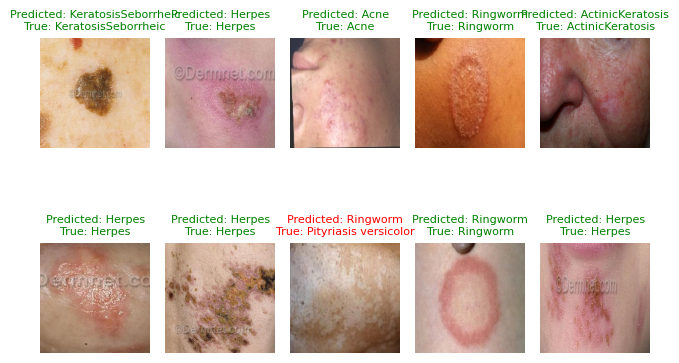

In [42]:
# Define a function to display images along with their predicted and true labels
def display_images_with_predictions(test_data, model, num_images=10):
    # Initialize a counter to keep track of displayed images
    num_displayed = 0
    
    # Set the font size for the titles
    font_size = 8
    
    # Iterate through the test data generator
    for images, labels in test_data:
        # Make predictions on the batch of images
        predictions = np.argmax(model.predict(images), axis=1)
        
        # Iterate through the batch
        for i in range(len(images)):
            # Display the image
            plt.subplot(2, 5, num_displayed + 1)
            plt.imshow(images[i])
            plt.axis('off')
            
            # Get the predicted and true labels
            predicted_label = class_labels[predictions[i]]
            true_label = class_labels[np.argmax(labels[i])]
            
            # Check if the prediction matches the true label
            if predicted_label == true_label:
                # If it matches, display the image with the predicted label
                plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}', fontsize=font_size, color='green')
            else:
                # If it doesn't match, display the image with the predicted and true labels
                plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}', fontsize=font_size, color='red')
            
            # Increment the counter
            num_displayed += 1
            
            # Check if the desired number of images have been displayed
            if num_displayed >= num_images:
                # If so, break out of the loop
                break
        
        # Check if the desired number of images have been displayed
        if num_displayed >= num_images:
            # If so, break out of the outer loop
            break

# Display 10 images along with their predictions and true labels
display_images_with_predictions(test_data, model, num_images=10)
plt.tight_layout()
plt.show()


In [43]:
# model.save('dermoally-modelv5.h5')

In [44]:
# !pip install tensorflowjs

In [45]:
# !tensorflowjs_converter --input_format keras /kaggle/working/dermoally-modelv5.h5 /kaggle/working/tfjs-modelv4

In [46]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the converted model to a file
# tflite_model_path = '/kaggle/working/dermoally-modelv5.tflite'
# with open(tflite_model_path, 'wb') as f:
#     f.write(tflite_model)

# print(f'TensorFlow Lite model saved to {tflite_model_path}')

In [47]:
# import shutil

# # Define the folder you want to zip
# folder_to_zip = '/kaggle/working/tfjs-modelv5'  # Replace with the path to your folder
# output_filename = '/kaggle/working/tfjs-modelv5.zip'

# # Create a zip file
# shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

# # The zip file is now available at the output path
# print(f'Folder zipped and saved as {output_filename}')